In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir")

options = Option(
    inputModel = 'KERAS_gru_model_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    jsonModel = 'KERAS_gru_model.json',
    outputDir = '/output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [4]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

#model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1680      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [5]:
# To use one data file:
h5File = h5py.File(options.inputFile, 'r')
treeArray = h5File[options.tree][()]

#print(treeArray.shape)
#print(treeArray.dtype.names)

# List of features to use
features = yamlConfig['Inputs']

# List of labels to use
labels = yamlConfig['Labels']

# Convert to dataframe
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

(24816, 5)


In [6]:
features_2dval = np.zeros((len(labels_df), yamlConfig['MaxParticles'], len(features)-1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values
    #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
    features_val_i = features_val[np.array(index_values),:]
    nParticles = len(features_val_i)
    #print("before", features_val_i[:,0])
    features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
    #print("after", features_val_i[:,0])
    if nParticles>yamlConfig['MaxParticles']:
        features_val_i =  features_val_i[0:yamlConfig['MaxParticles'],:]
    else:        
        features_val_i = np.concatenate([features_val_i, np.zeros((yamlConfig['MaxParticles']-nParticles, len(features)-1))])
    features_2dval[i, :, :] = features_val_i
    
features_val = features_2dval

X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [7]:
# Normalize conv inputs
reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train_val.shape[1]):
    X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
    X_test[:,p,:] = scaler.transform(X_test[:,p,:])    
if 'j_index' in labels:
    labels = labels[:-1]

In [8]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [9]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                    validation_split = 0.25, shuffle = True, callbacks = None, 
                    use_multiprocessing=True, workers=4)

Epoch 1/100
15/15 [==============================] - 1s 64ms/step - loss: 1.8715 - accuracy: 0.0942 - val_loss: 1.8592 - val_accuracy: 0.0921
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 1.8477 - accuracy: 0.0975 - val_loss: 1.8357 - val_accuracy: 0.0951
Epoch 3/100
15/15 [==============================] - 1s 42ms/step - loss: 1.8240 - accuracy: 0.1028 - val_loss: 1.8121 - val_accuracy: 0.0995
Epoch 4/100
15/15 [==============================] - 1s 47ms/step - loss: 1.8003 - accuracy: 0.1077 - val_loss: 1.7880 - val_accuracy: 0.1036
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 1.7765 - accuracy: 0.1155 - val_loss: 1.7631 - val_accuracy: 0.1076
Epoch 6/100
15/15 [==============================] - 1s 45ms/step - loss: 1.7510 - accuracy: 0.1276 - val_loss: 1.7371 - val_accuracy: 0.1151
Epoch 7/100
15/15 [==============================] - 1s 42ms/step - loss: 1.7252 - accuracy: 0.1412 - val_loss: 1.7099 - val_accuracy: 0.1277
Epoch 

15/15 [==============================] - 1s 48ms/step - loss: 0.3692 - accuracy: 0.8876 - val_loss: 0.3624 - val_accuracy: 0.8856
Epoch 59/100
15/15 [==============================] - 1s 47ms/step - loss: 0.3633 - accuracy: 0.8891 - val_loss: 0.3581 - val_accuracy: 0.8880
Epoch 60/100
15/15 [==============================] - 1s 41ms/step - loss: 0.3607 - accuracy: 0.8903 - val_loss: 0.3540 - val_accuracy: 0.8888
Epoch 61/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3548 - accuracy: 0.8914 - val_loss: 0.3499 - val_accuracy: 0.8894
Epoch 62/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3502 - accuracy: 0.8917 - val_loss: 0.3458 - val_accuracy: 0.8902
Epoch 63/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3457 - accuracy: 0.8925 - val_loss: 0.3418 - val_accuracy: 0.8906
Epoch 64/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3418 - accuracy: 0.8939 - val_loss: 0.3378 - val_accuracy: 0.8918
Epoch 65/100

In [10]:
model.save('GRU') #Saves to local directory;

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: GRU\assets


In [11]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

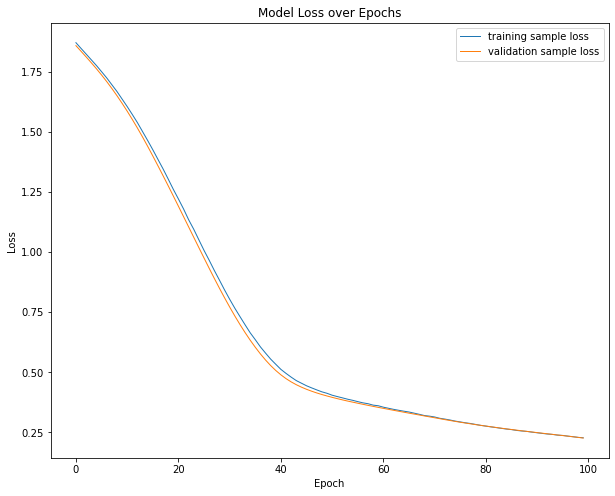

In [12]:
learningCurve(history)

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

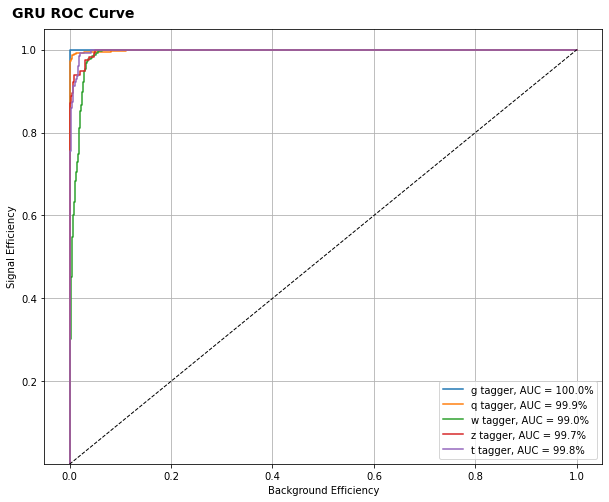

In [14]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='GRU')